In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import torch
import random
device = 'cuda' if torch.cuda.is_available() else 'cpu'
from scipy.ndimage import gaussian_filter
import sys
from tqdm import tqdm
from functools import partial
import acd
from copy import deepcopy
sys.path.append('..')
sys.path.append('../..')
from transforms_torch import bandpass_filter
# plt.style.use('dark_background')
sys.path.append('../../dsets/mnist')
import dset
from model import Net, Net2c
from util import *
from numpy.fft import *
from torch import nn
from style import *
from captum.attr import (
    InputXGradient,
    Saliency,
    GradientShap,
    DeepLift,
    DeepLiftShap,
    IntegratedGradients,
    LayerConductance,
    NeuronConductance,
    NoiseTunnel,
)
import pickle as pkl
from torchvision import datasets, transforms
from sklearn.decomposition import NMF
import transform_wrappers
import visualize as viz
torch.manual_seed(42)
np.random.seed(42)

In [2]:
sys.path.append('../../..')
# from hierarchical_dnn_interpretations.acd.scores import cd as acd
from acd_wooseok.acd.scores import cd
from acd_wooseok.acd.util import tiling_2d
from knockout_nmf import *

# Dataset

In [3]:
# load args
args = dset.get_args()
args.epochs = 20
args.cuda = not args.no_cuda and torch.cuda.is_available()

# load the model
model = Net().to(device)
model.load_state_dict(torch.load('../../dsets/mnist/mnist.model', map_location=device))
model = model.eval()

# data_loader
train_loader, test_loader = dset.load_data(args.batch_size, args.test_batch_size, device)

# NMF in the hidden layers

In [4]:
# run NMF
# nmf = NMF(n_components=15, max_iter=1000)
# nmf.fit(middle_layer)
# pkl.dump(nmf, open('./results/nmf_actmap_30.pkl', 'wb'))
nmf = pkl.load(open('./results/nmf_actmap_30.pkl', 'rb'))  

In [5]:
# middle layer features
mods = list(model.modules())[1:8]
middle_layer = []
for i, (data, targets) in enumerate(test_loader):
    if device == 'cuda':
        data = data.to(device)
    for mod in mods:
        data = mod(data)
    middle_layer.append(data.data.cpu().numpy().reshape(-1,320))
middle_layer = np.vstack(middle_layer)
Y_test = test_loader.dataset.targets.numpy()

D = nmf.components_
for i in range(nmf.n_components):
    D[i] = D[i]/np.linalg.norm(D[i])
nmf.components_ = D
W = nmf.transform(middle_layer)
print('recon error:', np.linalg.norm(W @ D - middle_layer) / np.linalg.norm(middle_layer))

recon error: 0.35351383676895953


In [6]:
basis_indx_counts = {}
basis_indxes_sorted = []
for i in range(10):
    basis_indxes, counts = np.unique(np.argmax(W,axis=1)[Y_test==i], return_counts=True)
    basis_indx_counts['label{}'.format(i)] = basis_indxes[np.argsort(counts)[::-1]]
    basis_indxes_sorted += list(basis_indxes[np.argsort(counts)[::-1]][:3])
list_of_x = np.repeat([i for i in range(10)], 3)

In [7]:
for i in range(10):
    print('digit{}:'.format(i), basis_indx_counts['label{}'.format(i)][:3])

digit0: [ 4 24 20]
digit1: [10  1 23]
digit2: [ 5  1 15]
digit3: [0 7 6]
digit4: [22 11  3]
digit5: [13  7  8]
digit6: [26 17  2]
digit7: [28 25 29]
digit8: [ 8 19 14]
digit9: [ 3 11 27]


In [8]:
basis_indx_counts

{'label0': array([ 4, 24, 20,  9, 19, 17, 12,  2, 27, 18, 25, 23, 14,  8,  1]),
 'label1': array([10,  1, 23, 14, 29,  6,  2, 25, 15,  8,  0]),
 'label2': array([ 5,  1, 15, 16,  6,  2, 21, 28, 12, 14, 20, 19, 10, 25, 23,  8, 24,
        17,  9,  0]),
 'label3': array([ 0,  7,  6, 15, 28, 20, 21, 11, 16,  8,  2, 19,  5, 18, 10, 25,  3,
        27, 14]),
 'label4': array([22, 11,  3, 27, 17, 29, 23, 26, 25, 18, 16, 12, 10,  4, 21,  9, 14,
         8,  7]),
 'label5': array([13,  7,  8,  0, 20,  9, 11, 27, 10, 18,  2, 25, 26,  4,  3, 28, 14,
        23, 15,  5]),
 'label6': array([26, 17,  2, 23, 19, 20,  4, 13, 10, 27, 24,  3, 16,  8,  7,  1,  0]),
 'label7': array([28, 25, 29, 12,  1,  9, 18,  6, 15, 21, 16, 10, 17,  7,  4, 14,  3,
         2, 11, 27,  8, 23]),
 'label8': array([ 8, 19, 14, 11, 21, 12, 27,  7, 29, 28, 10,  2, 26, 20,  4, 24, 15,
        13, 22,  0, 18,  6, 17,  5, 23,  1,  9]),
 'label9': array([ 3, 11, 27, 29, 25, 21, 12, 18,  8,  9, 10,  7, 17, 20,  4, 26,  1])}

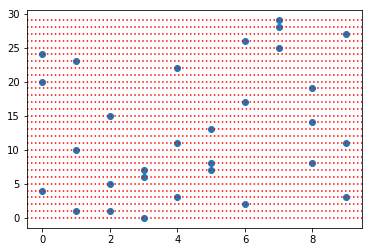

In [21]:
plt.scatter(list_of_x, basis_indxes_sorted)
for i in range(nmf.n_components):
    plt.axhline(y=i, color='r', linestyle=':')
plt.show()

# Relevant * NMF dictionaries

In [313]:
import cd_temp_wooseok 
results = {
    'pixel_scores': [], # (784, 20, 4, 4)
    'corr': [], # (784, 30)
    'feature_maps': [], # (1, 20, 4, 4)
    'dict_scores': [] # (30, 10)
}
for i in range(50):
    # transform layers
    norm = transform_wrappers.NormLayer(mu=0.1307, std=0.3081)
    norm_rel = transform_wrappers.NormLayer(mu=0.0, std=0.3081) 
    
    # test image
    x = X_test[i:i+1]
    im = norm(torch.Tensor(x)).reshape(28,28)
    im_rel = norm_rel(torch.Tensor(x)).reshape(28,28) 
    
    # pixel by cd-score and correlation
    tiles = torch.Tensor(tiling_2d.gen_tiles(im, fill=0, method='cd', sweep_dim=1))
    cd_scores_im = []
    rel_corr = []
    for j in range(28*28):  # can use tqdm here, need to use batches
        relevant = im_rel * tiles[j]
        cd_score = cd_temp_wooseok.cd(im, model, mask=None, model_type='mnist', device='cuda', transform=None,
                                 relevant=relevant)
        cd_scores_im.append(cd_score[0].data.cpu().numpy())
        rel_corr.append((cd_scores_im[-1].flatten() * D).sum(axis=1))
    cd_scores_im = np.squeeze(np.array(cd_scores_im))
    rel_corr = np.array(rel_corr)
    results['pixel_scores'].append(deepcopy(cd_scores_im))
    results['corr'].append(deepcopy(rel_corr))
    output = (cd_score[0] + cd_score[1]).data.cpu().numpy()
    results['feature_maps'].append(deepcopy(output))
    
    # dictionary by cd-score
    # transform layer
    transformer = transform_wrappers.lay_from_w(D).to(device)
    
    # weights
    x_t = nmf.transform(deepcopy(output).reshape(1,-1))
    x_t_tensor = torch.Tensor(x_t).to(device)
    output = torch.Tensor(output).to(device)
    
    # cd score over dictionary
    tiles = torch.Tensor(tiling_2d.gen_tiles(x_t, fill=0, method='cd', sweep_dim=1)).to(device)
    cd_scores_dict = []
    for j in range(nmf.n_components):
        relevant = transformer(tiles[j] * x_t_tensor).reshape(1,20,4,4)
        cd_score = cd_temp_wooseok.cd(output, model, mask=None, model_type='mnist', device='cuda', transform=None,
                                 relevant=relevant, ver=1) 
        cd_scores_dict.append(cd_score[0].data.cpu().numpy())
    cd_scores_dict = np.squeeze(np.array(cd_scores_dict))
    results['dict_scores'].append(deepcopy(cd_scores_dict))
    
    print('\riteration:', i, end='')

iteration: 49

# Visualize pixel-by-pixel correlation 

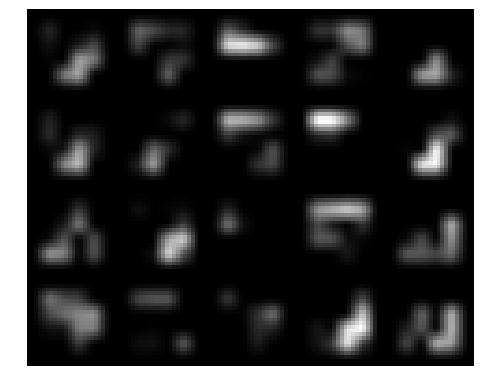

In [314]:
from skimage.transform import rescale
# plot of activation maps

plt.figure(figsize=(8,8))
n_row = 4
n_col = 5
p = 4 + 2
mosaic = np.zeros((p*n_row,p*n_col))
indx = 0
for i in range(n_row):
    for j in range(n_col):
        mosaic[i*p:(i+1)*p,j*p:(j+1)*p] = np.pad(results['feature_maps'][img_indx][0][indx],(1,1),mode='constant')
        indx += 1

plt.imshow(rescale(mosaic,4,mode='constant'), cmap='gray')
plt.axis('off')
plt.show()        

class label 9


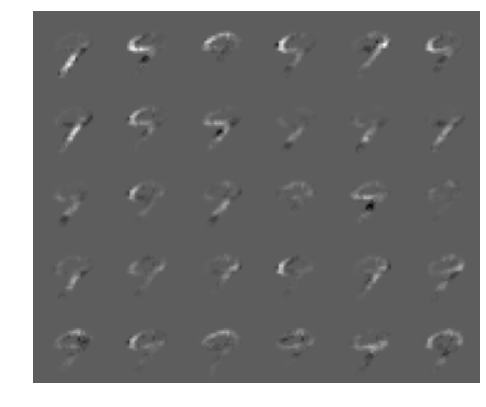

In [331]:
from skimage.transform import rescale
# plot of activation maps
img_indx = 9
label_indx = Y_test[img_indx]
ranking_indxs = np.argsort(results['dict_scores'][img_indx][:,label_indx])[::-1]

plt.figure(figsize=(8,8))
n_row = 5
n_col = 6
p = 28 + 2
mosaic = np.zeros((p*n_row,p*n_col))
n = 0
for i in range(n_row):
    for j in range(n_col):
        indx = ranking_indxs[n]
        mosaic[i*p:(i+1)*p,j*p:(j+1)*p] = np.pad(results['corr'][img_indx].T.reshape(-1,28,28)[indx],(1,1),mode='constant')
        n += 1

plt.imshow(rescale(mosaic,4,mode='constant'), cmap='gray')
plt.axis('off')
print('class label', label_indx)
plt.show()        

In [332]:
np.sort(results['dict_scores'][img_indx][:,label_indx])[::-1]

array([ 4.3876710e+00,  3.7326779e+00,  1.1656213e+00,  8.4077364e-01,
        3.2856518e-01,  1.8551150e-01,  1.7736083e-01,  7.0191853e-02,
        4.1045215e-02,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
        0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
        0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
        0.0000000e+00,  0.0000000e+00,  0.0000000e+00, -2.2464916e-03,
       -2.3361593e-02, -3.3645585e-02, -4.8463047e-02, -5.6736872e-02,
       -1.1320205e-01, -1.9058880e-01], dtype=float32)

# CD score for dictionary

In [316]:
labe_indx = 0
channel_indx = 0
dict_indx = 13
D_ = D.reshape(-1,20,4,4)

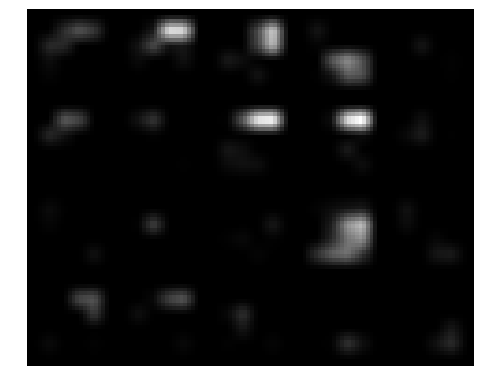

In [317]:
from skimage.transform import rescale
# plot of activation maps

plt.figure(figsize=(8,8))
n_row = 4
n_col = 5
p = 4 + 2
mosaic = np.zeros((p*n_row,p*n_col))
indx = 0
for i in range(n_row):
    for j in range(n_col):
        mosaic[i*p:(i+1)*p,j*p:(j+1)*p] = np.pad(D_[dict_indx][indx],(1,1),mode='constant')
        indx += 1

plt.imshow(rescale(mosaic,4,mode='constant'), cmap='gray')
plt.axis('off')
plt.show()        

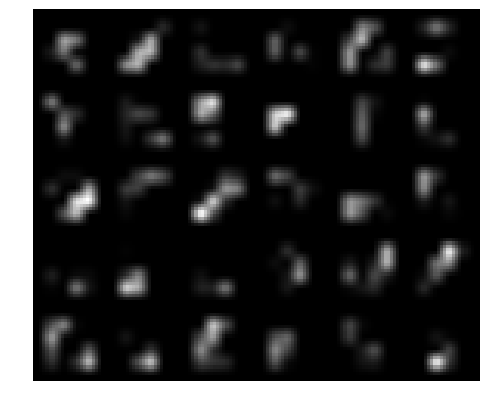

In [318]:
from skimage.transform import rescale
# plot of activation maps

plt.figure(figsize=(8,8))
n_row = 5
n_col = 6
p = 4 + 2
mosaic = np.zeros((p*n_row,p*n_col))
indx = 0
for i in range(n_row):
    for j in range(n_col):
        mosaic[i*p:(i+1)*p,j*p:(j+1)*p] = np.pad(D_[indx][channel_indx],(1,1),mode='constant')
        indx += 1

plt.imshow(rescale(mosaic,4,mode='constant'), cmap='gray')
plt.axis('off')
plt.show()        